# Squeezed Lasing: squeezing spectrum

In [44]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [45]:
def H_def(a_s,sigma,delta_s,delta_sigma,g_0,r,omega,phi): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return delta_s*a_s*a_s.dag()+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())+omega*(a_s*np.exp(1j*phi)+a_s.dag()*np.exp(-1j*phi))

In [46]:
def Lops_def(a_s,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

#### Parameters

In [47]:
### General parameters ###

N = 60 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
g_0 = 1 # Light-matter coupling
C = 0.5 # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels
delta_c = 1 # Detuning w_c-w_p

### Squeezed parameters ###

r = 1 # Squeezing parameter
theta = np.pi # Squeezing angle

### Symmetry broken parameters ###

omega = 0 # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [48]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = delta_s # Detuning w_sigma-w_p (the same as delta_s to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

Check RWA conditions

In [49]:
print(delta_c,delta_s,delta_sigma,g_0*np.sinh(r))

1 0.2658022288340796 0.2658022288340796 1.1752011936438014


In [7]:
aux = 1

if delta_sigma > aux*g_0*np.sinh(r):
    if delta_s > aux*g_0*np.sinh(r):
        print('double check')
    else:
        print('Check values of delta_c')
else:
    print('Check value of r')

Check value of r


#### Operators

In [8]:
a_s = tensor(destroy(N),identity(2)) # Annihilation operator of the squeezed basis
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a_s*a_s-np.conj(r*np.exp(-1j*theta))*a_s.dag()*a_s.dag())).expm() # Squeezing operator

#### Hamiltonian

In [9]:
H = H_def(a_s,sigma,delta_s,delta_sigma,g_0,r,omega,phi) # Iniatilize the hamiltonian for the chosen parameters

#### Collapse operators

In [10]:
Lops = Lops_def(a_s,sigma,k,P,eta)

#### Initial state

In [11]:
psi_0 = tensor(displace(N,np.sqrt(0)*np.exp(1j*(np.pi-theta/2)))*basis(N),basis(2,1))
rho_0 = psi_0*psi_0.dag()

In [23]:
result = mesolve(H, rho_0, np.linspace(0,5/k,5), Lops,  [], options=Options(nsteps=10000))

In [13]:
'''
var=[]
dt=np.linspace(0,10/k,100)[1]

for i in range(100):
    quad_ang = np.pi-(theta)/2-dt*i*delta_s # Quadrature angle that specifies the field's quadrature to measure
    X_ang_s = a_s*np.exp(-1j*quad_ang)+a_s.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator
    X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator
    var.append(variance(X_ang,result.states[i]))
'''

"\nvar=[]\ndt=np.linspace(0,10/k,100)[1]\n\nfor i in range(100):\n    quad_ang = np.pi-(theta)/2-dt*i*delta_s # Quadrature angle that specifies the field's quadrature to measure\n    X_ang_s = a_s*np.exp(-1j*quad_ang)+a_s.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator\n    X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator\n    var.append(variance(X_ang,result.states[i]))\n"

In [26]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator
X_ang_s = a_s*np.exp(-1j*quad_ang)+a_s.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator
var = variance(X_ang,result.states)

In [28]:
var[0]

0.1353352832366127

Text(0, 0.5, '$\\Delta X_{\\pi-\\frac{\\theta}{2}}$')

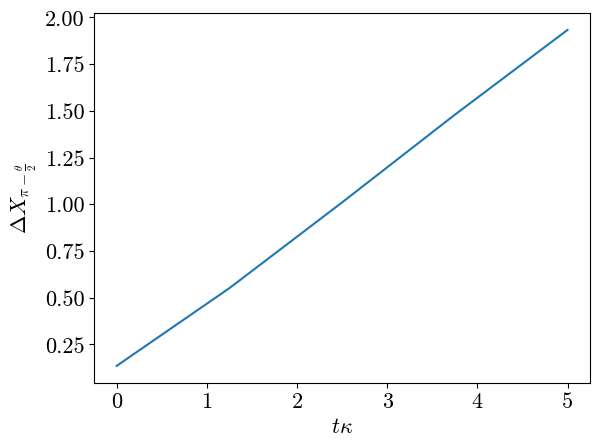

In [27]:
plt.plot(np.linspace(0,5,5),var)
plt.xlabel(r'$t\kappa$')
plt.ylabel(r'$\Delta X_{\pi-\frac{\theta}{2}}$')

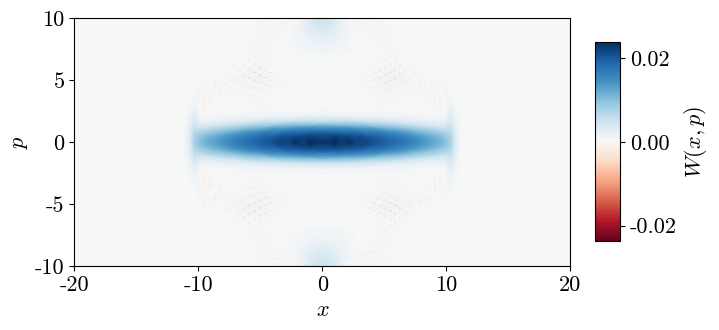

In [31]:
wigner_rep(S*result.states[3]*S.dag()).wigner_plot(20,10)

#### Squeezed quadrature

In [18]:
sp = spec_prop(a,H,Lops) # Intialize the spec_prop class to compute the spectral properties of the system

In [19]:
quad_ang = (theta)/2 # Angle of the quadrature for which the squeezing spectrum will be computed
tvec, freqs, sq_spec = sp.squeezed_spec(rho_0,k,quad_ang,t_f=5,tau_f=150) # Calculation of the squeezing spectrum and its time evolution from rho_0

  0%|          | 0/5 [00:00<?, ?it/s]c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_a[i,:] = no_fluc.expect[0]
c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_ad[i,:] = no_fluc.expect[1]
  0%|          | 0/5 [00:00<?, ?it/s]c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i,:] = np.exp(-1j*2*quad_ang)*(corr_aa[i,:]-mean_a[0,:]*mean_a[i,:])+(corr_aad[i,:]-mean_ad[0,:]*mean_a[i,:])+(corr_ada[i,:]-mean_a[0,:]*mean_ad[i,:])+np.exp(1j*2*quad_ang)*(corr_adad[i,:]-mean_ad[0,:]*mean_ad[i,:])
100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Text(0, 0.5, '$\\Delta X_{\\pi-\\frac{\\theta}{2}}$')

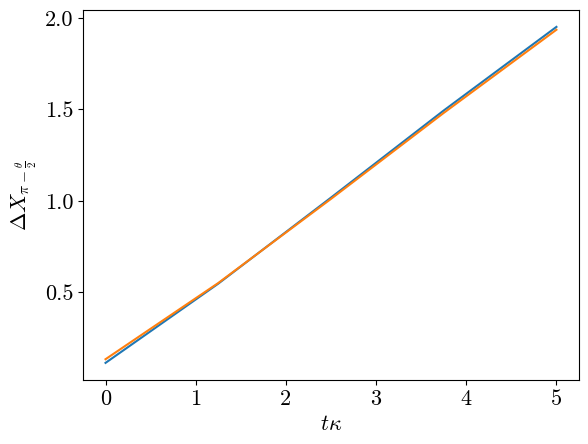

In [32]:
plt.plot(np.linspace(0,5,5),[(1/(2*np.pi*k))*scipy.integrate.simpson(sq_spec[i],freqs)+1 for i in range(5)])
plt.plot(np.linspace(0,5,5),var)
plt.xlabel(r'$t\kappa$')
plt.ylabel(r'$\Delta X_{\pi-\frac{\theta}{2}}$')

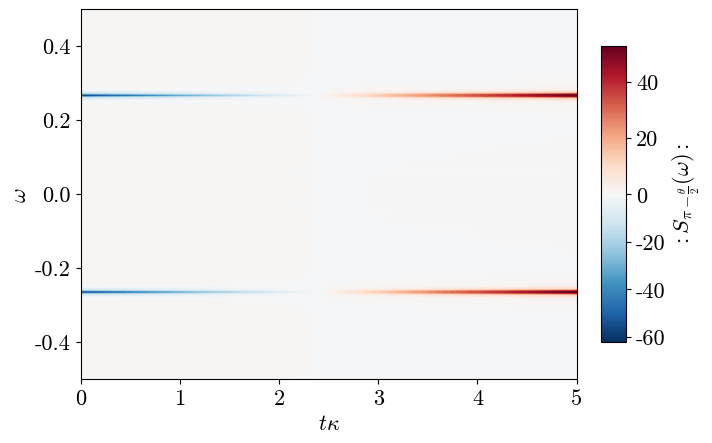

In [33]:
fig2, ax2 = plt.subplots()
nrm = colors.TwoSlopeNorm(vmin=np.min(sq_spec), vcenter=0, vmax=np.max(sq_spec)) # Colorbar settings
cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r), cax = ax2.inset_axes([1.05, 0.1, 0.05, 0.8]),label=r'$:S_{\pi-\frac{\theta}{2}}(\omega):$') 
ax2.contourf(tvec*k, freqs, np.transpose(sq_spec), 100, cmap=cm.RdBu_r, norm=nrm)
ax2.set_xlabel(r'$t\kappa$')
ax2.set_ylabel(r'$\omega$')
#ax.set_ylim([-100,100])
plt.show()
#fig2.savefig('.\SEC_VI_A/sq_spec.png',dpi=500, bbox_inches = 'tight')

In [34]:
esp = np.column_stack([freqs,np.transpose(sq_spec)])
np.savetxt('.\SEC_VI_A/SQUEE_SPEC_'+str(format(delta_s,'.3f'))+'_'+str(format(C,'.1f'))+'_'+str(format(r,'.2f'))+'.txt',esp)

In [23]:
''' Sin poner es squeeze operator en rho_0 y con 110 fotones y 40 tau vec, me tardó más de 580 minutos
plt.plot(freqs,sq_spec[1],label='$t\kappa$='+str(tvec[1]*k))
plt.plot(freqs,sq_spec[0],label='$t\kappa$='+str(tvec[0]*k))
#plt.plot([np.min(freqs/k),np.max(freqs/k)],[0,0],'--',color = 'k')
plt.xlabel('$\omega/\kappa$')
plt.ylabel(r'$:S_{\theta/2}(\omega):$')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()
'''

" Sin poner es squeeze operator en rho_0 y con 110 fotones y 40 tau vec, me tardó más de 580 minutos\nplt.plot(freqs,sq_spec[1],label='$t\\kappa$='+str(tvec[1]*k))\nplt.plot(freqs,sq_spec[0],label='$t\\kappa$='+str(tvec[0]*k))\n#plt.plot([np.min(freqs/k),np.max(freqs/k)],[0,0],'--',color = 'k')\nplt.xlabel('$\\omega/\\kappa$')\nplt.ylabel(r'$:S_{\theta/2}(\\omega):$')\nplt.xlim([-0.5,0.5])\nplt.legend()\nplt.show()\n"

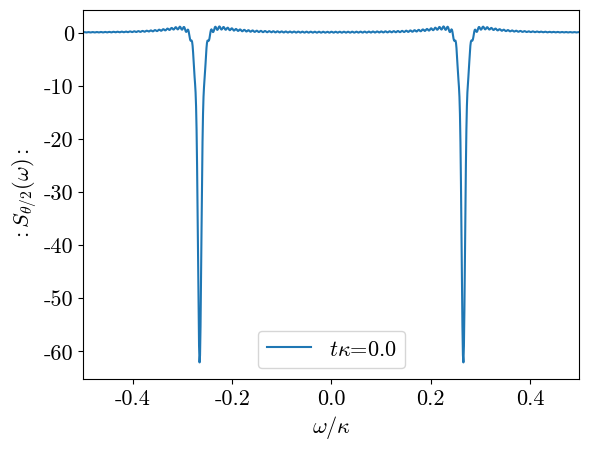

In [37]:
plt.plot(freqs,sq_spec[0],label='$t\kappa$='+str(tvec[0]*k))
#plt.plot(freqs,sq_spec[0],label='$t\kappa$='+str(tvec[0]*k))
#plt.plot([np.min(freqs/k),np.max(freqs/k)],[0,0],'--',color = 'k')
plt.xlabel('$\omega/\kappa$')
plt.ylabel(r'$:S_{\theta/2}(\omega):$')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()

#### Antisqueezed quadrature

In [32]:
quad_ang = np.pi-(theta+np.pi)/2 # Angle of the quadrature for which the squeezing spectrum will be computed
a_tvec, a_freqs, asq_spec = sp.squeezed_spec(rho_0,k,quad_ang,t_f=5,tau_f=150) # Calculation of the squeezing spectrum and its time evolution from rho_0

  0%|          | 0/5 [00:00<?, ?it/s]c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_a[i,:] = no_fluc.expect[0]
c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:166: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_ad[i,:] = no_fluc.expect[1]
  0%|          | 0/5 [00:00<?, ?it/s]c:\users\rodri\onedrive\documentos\github\squeezed-lasing\squeezed_lasing\src_2_0.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i,:] = np.exp(-1j*2*quad_ang)*(corr_aa[i,:]-mean_a[0,:]*mean_a[i,:])+(corr_aad[i,:]-mean_ad[0,:]*mean_a[i,:])+(corr_ada[i,:]-mean_a[0,:]*mean_ad[i,:])+np.exp(1j*2*quad_ang)*(corr_adad[i,:]-mean_ad[0,:]*mean_ad[i,:])
100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


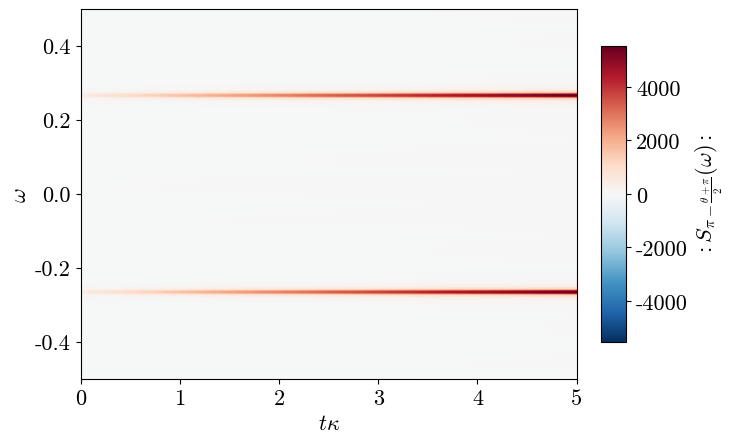

In [91]:
fig, ax = plt.subplots()
nrm = colors.Normalize(-np.max(asq_spec), np.max(asq_spec)) # Colorbar settings
cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r), cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]), label=r'$:S_{\pi-\frac{\theta+\pi}{2}}(\omega):$') 
ax.contourf(tvec*k, freqs, np.transpose(asq_spec), 100, cmap=cm.RdBu_r, norm=nrm)
ax.set_xlabel(r'$t\kappa$')
ax.set_ylabel(r'$\omega$')
plt.show()
fig.savefig('.\SEC_VI_A/asq_spec.png',dpi=500, bbox_inches = 'tight')

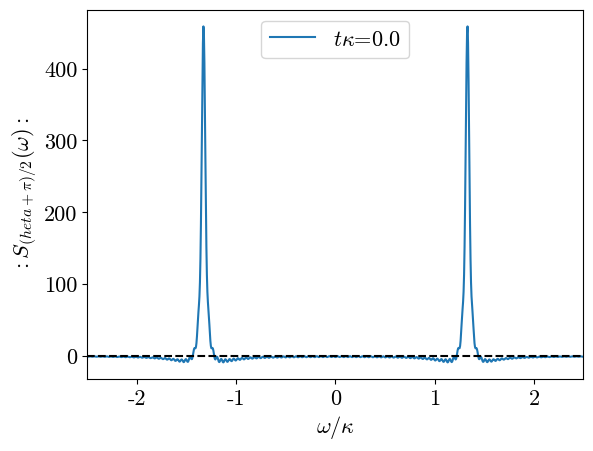

In [55]:
#plt.plot(freqs/k,asq_spec[-1],label='$t\kappa$='+str(tvec[-1]*k))
plt.plot(freqs/k,asq_spec[0],label='$t\kappa$='+str(tvec[0]*k))
plt.plot([np.min(freqs/k),np.max(freqs/k)],[0,0],'--',color = 'k')
plt.xlabel('$\omega/\kappa$')
plt.ylabel('$:S_{(\theta+\pi)/2}(\omega):$')
plt.xlim([np.min(freqs/k),np.max(freqs/k)])
plt.legend()
plt.show()

In [42]:
esp = np.column_stack([a_freqs,np.transpose(asq_spec)])
np.savetxt('.\SEC_VI_A/ANTISQUEE_SPEC_'+str(format(delta_s,'.3f'))+'_'+str(format(C,'.1f'))+'_'+str(format(r,'.2f'))+'.txt',esp)